In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# box-cox transformation for skeewed data
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# data transformation functions

# find best boxcox transformation. Include datetime index if given
def boxcox_transform(x,lmda=None,alpha=None,optimizer=None):
    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.Series(data=boxcox_data, index=index, name=name)
            
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    else:
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)
            return boxcox_data

# reverse transformation. Include datetime index if given
def inv_boxcox_tranform(x, lmda, out=None):

    reversed_data = inv_boxcox(x, lmda, out=None)

    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name

        reversed_data = pd.DataFrame(reversed_data, index=index, columns=[name])

        return reversed_data

    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        
        return reversed_data
        
    else:
        return reversed_data


import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# make list with dma names
dma_list = list(inflow_data.columns.values)

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# # print first two rows
# inflow_data.head(3)

In [2]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

# drop uncorrelated features
#weather_data = weather_data.drop(['Rainfall depth (mm)','Air humidity (%)','Windspeed (km/h)'], axis=1)

In [3]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

In [4]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-01-17'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

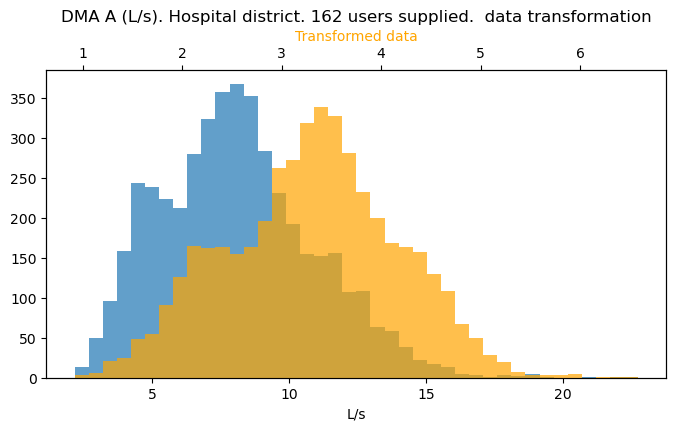

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10688D-01    |proj g|=  4.67116D-01

At iterate    5    f=  6.24688D-01    |proj g|=  3.13040D-01

At iterate   10    f=  5.90975D-01    |proj g|=  9.54196D-01

At iterate   15    f=  5.84706D-01    |proj g|=  5.57548D-01

At iterate   20    f=  5.79099D-01    |proj g|=  5.18248D-01

At iterate   25    f=  5.70932D-01    |proj g|=  2.14631D-01

At iterate   30    f=  5.57395D-01    |proj g|=  5.59648D-01

At iterate   35    f=  5.51080D-01    |proj g|=  4.28037D-01

At iterate   40    f=  5.43243D-01    |proj g|=  1.17127D-01

At iterate   45    f=  5.39089D-01    |proj g|=  3.08153D-01

At iterate   50    f=  5.36728D-01    |proj g|=  1.55007D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

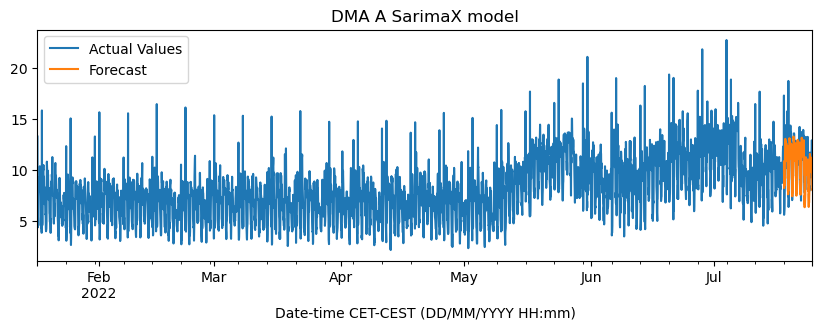

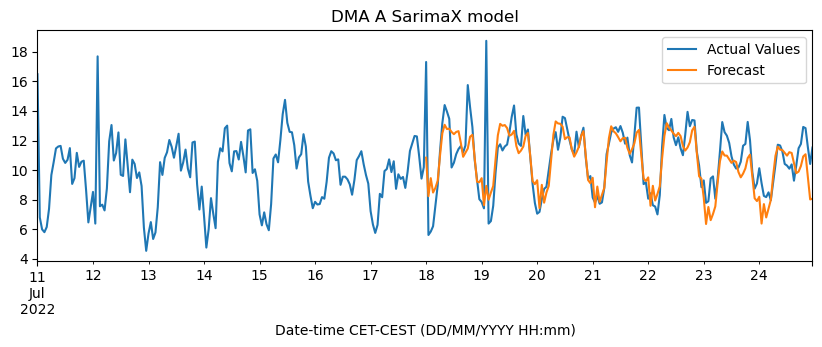

Performance indicators
DMA A SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.54            6.46             0.95           8.96 

Performance indicators


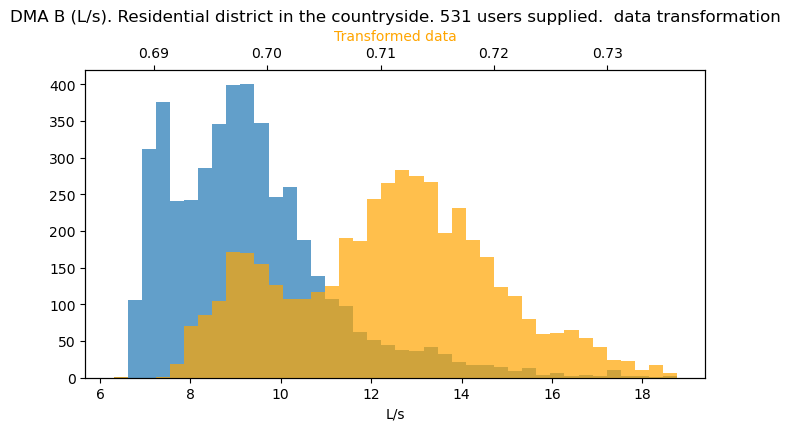

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.27893D+00    |proj g|=  3.73358D+02


 This problem is unconstrained.



At iterate    5    f= -4.31041D+00    |proj g|=  5.27828D+02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17      9     29      1     0     0   2.763D+01  -4.326D+00
  F =  -4.3264414805762330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


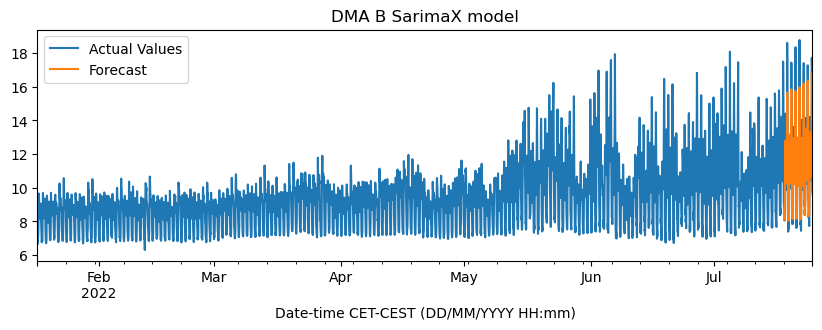

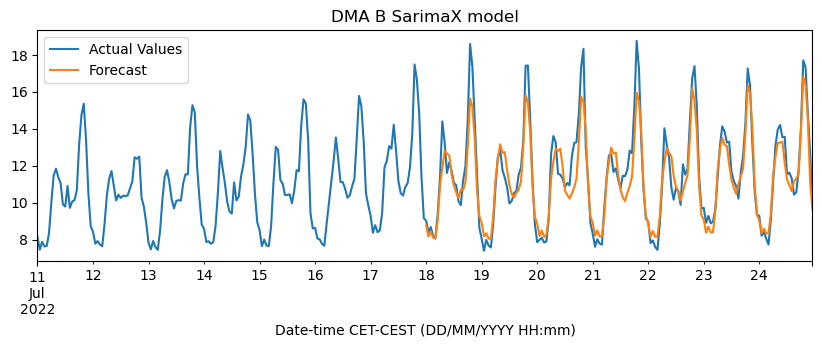

Performance indicators
DMA B SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.76            2.96             0.71           4.43 

Performance indicators


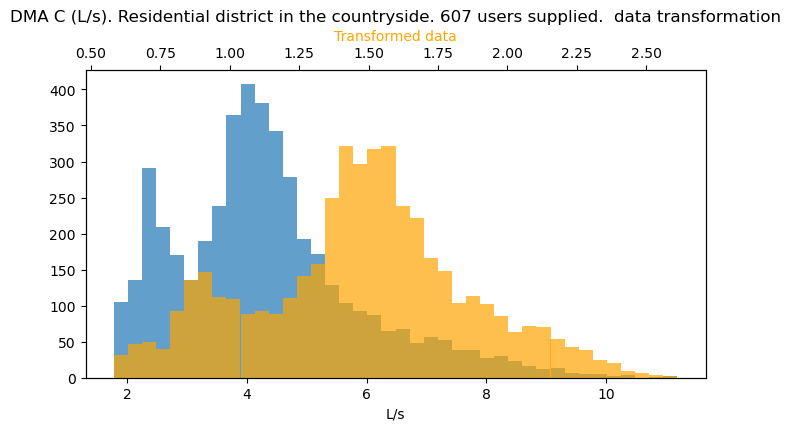

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.23829D-01    |proj g|=  2.16018D+00


 This problem is unconstrained.



At iterate    5    f= -9.42499D-01    |proj g|=  1.95685D-01

At iterate   10    f= -9.45822D-01    |proj g|=  8.91958D-01

At iterate   15    f= -9.48964D-01    |proj g|=  2.92213D-01

At iterate   20    f= -9.54232D-01    |proj g|=  3.69313D+00

At iterate   25    f= -9.60882D-01    |proj g|=  2.41797D-01

At iterate   30    f= -9.65493D-01    |proj g|=  7.97548D-01

At iterate   35    f= -9.85010D-01    |proj g|=  6.67054D-01

At iterate   40    f= -9.87657D-01    |proj g|=  4.59152D-01

At iterate   45    f= -9.90821D-01    |proj g|=  1.00647D+00

At iterate   50    f= -9.97936D-01    |proj g|=  7.82622D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

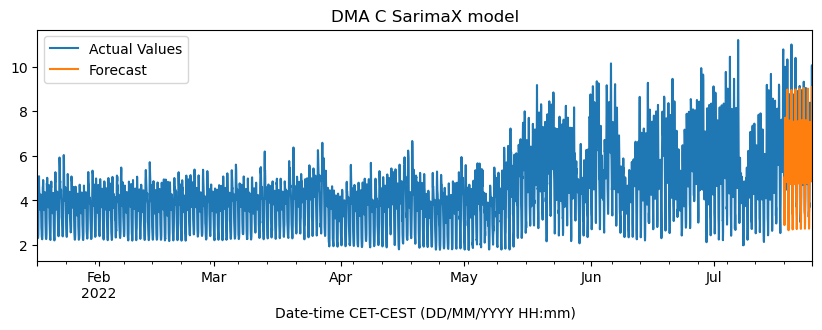

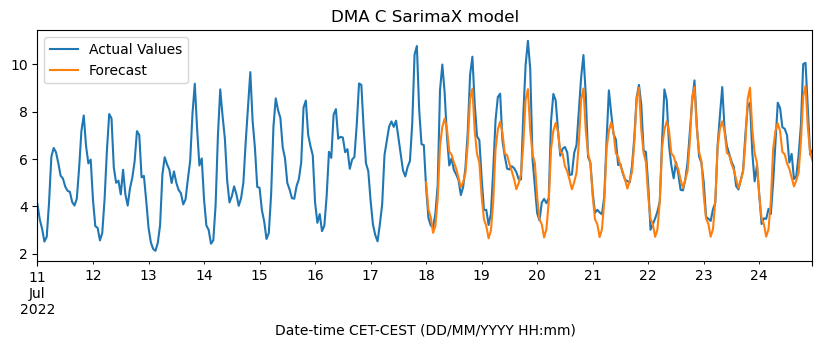

Performance indicators
DMA C SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.69            2.63             0.58           3.90 

Performance indicators


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43384D+00    |proj g|=  9.45697D-02

At iterate    5    f=  2.35970D+00    |proj g|=  1.76970D-01

At iterate   10    f=  2.33835D+00    |proj g|=  3.72581D-02

At iterate   15    f=  2.32998D+00    |proj g|=  3.01475D-02

At iterate   20    f=  2.32814D+00    |proj g|=  8.47850D-03

At iterate   25    f=  2.32804D+00    |proj g|=  3.65895D-03

At iterate   30    f=  2.32797D+00    |proj g|=  2.86156D-03

At iterate   35    f=  2.32795D+00    |proj g|=  1.22962D-03

At iterate   40    f=  2.32794D+00    |proj g|=  8.53430D-03

At iterate   45    f=  2.32791D+00    |proj g|=  5.83326D-03

At iterate   50    f=  2.32789D+00    |proj g|=  1.63652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

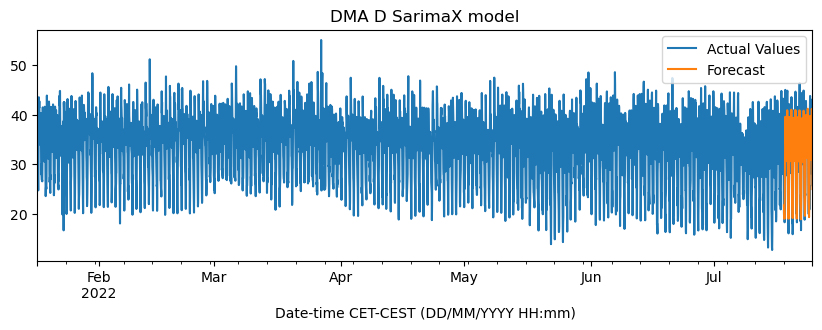

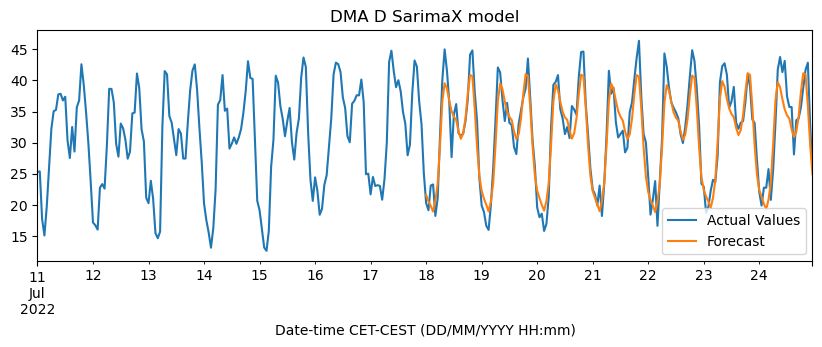

Performance indicators
DMA D SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.32            7.40             2.34           12.05 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43995D+00    |proj g|=  8.40294D-02

At iterate    5    f=  2.40935D+00    |proj g|=  2.75682D-01

At iterate   10    f=  2.33053D+00    |proj g|=  3.46364D-02

At iterate   15    f=  2.32593D+00    |proj g|=  1.41165D-02

At iterate   20    f=  2.32515D+00    |proj g|=  2.01753D-03

At iterate   25    f=  2.32504D+00    |proj g|=  4.52555D-03

At iterate   30    f=  2.32488D+00    |proj g|=  3.21410D-03

At iterate   35    f=  2.32466D+00    |proj g|=  2.50858D-03

At iterate   40    f=  2.32418D+00    |proj g|=  7.86225D-03

At iterate   45    f=  2.32327D+00    |proj g|=  2.52806D-02

At iterate   50    f=  2.32067D+00    |proj g|=  3.57006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

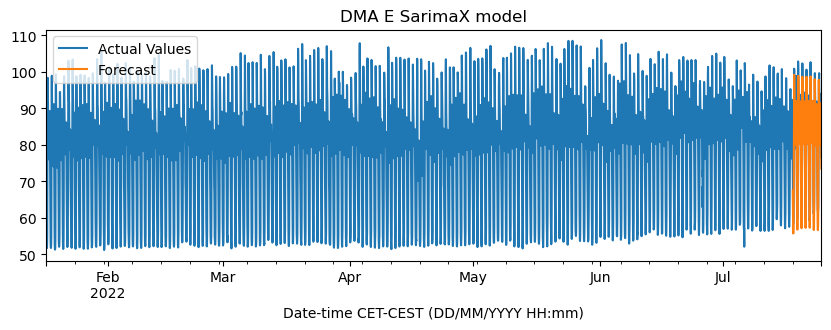

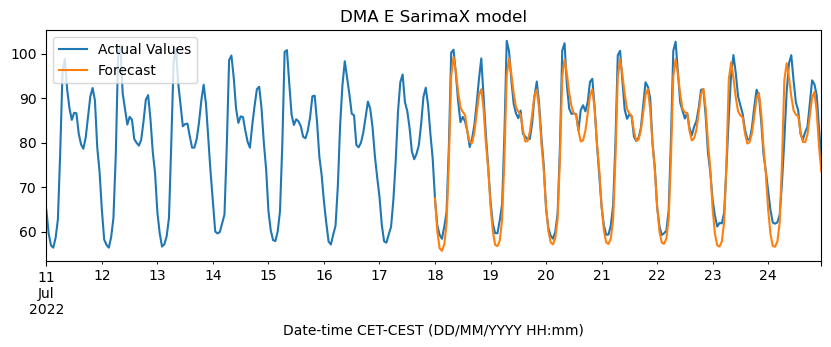

Performance indicators
DMA E SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.25            6.90             2.41           11.56 



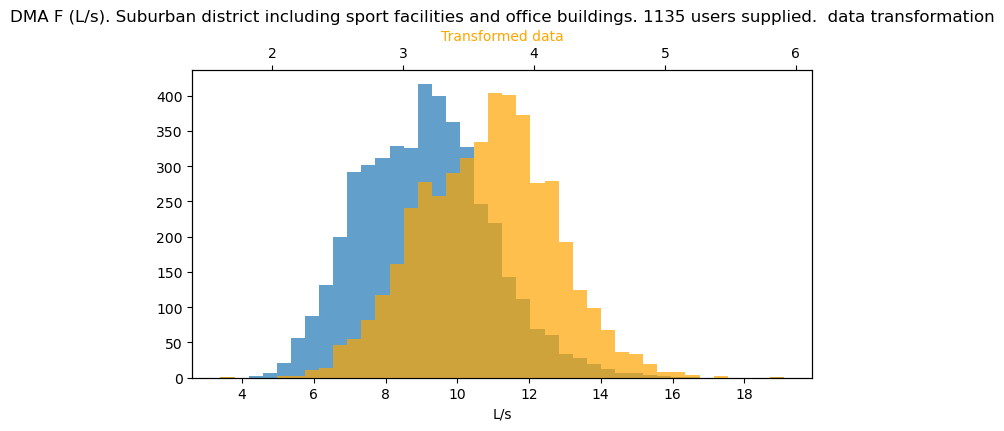

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31256D-01    |proj g|=  9.44932D-01

At iterate    5    f=  1.91639D-01    |proj g|=  2.37309D-01

At iterate   10    f=  1.87382D-01    |proj g|=  8.64356D-01

At iterate   15    f=  1.60360D-01    |proj g|=  4.69738D-01

At iterate   20    f=  1.54017D-01    |proj g|=  2.23464D-01

At iterate   25    f=  1.51040D-01    |proj g|=  2.28047D-01

At iterate   30    f=  1.41107D-01    |proj g|=  1.09085D+00

At iterate   35    f=  1.39913D-01    |proj g|=  2.05230D-01

At iterate   40    f=  1.39402D-01    |proj g|=  1.70826D-01

At iterate   45    f=  1.38994D-01    |proj g|=  4.86206D-02

At iterate   50    f=  1.38924D-01    |proj g|=  2.01488D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

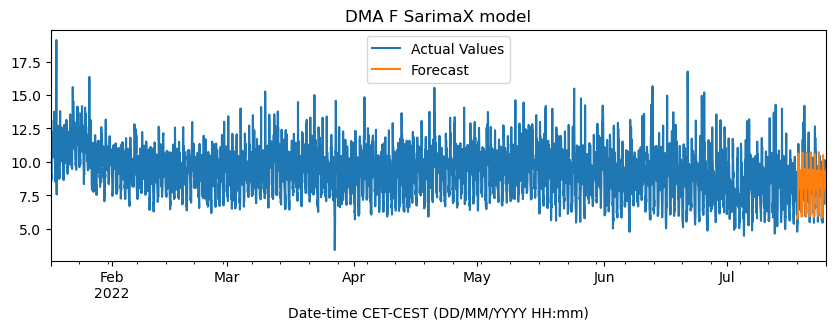

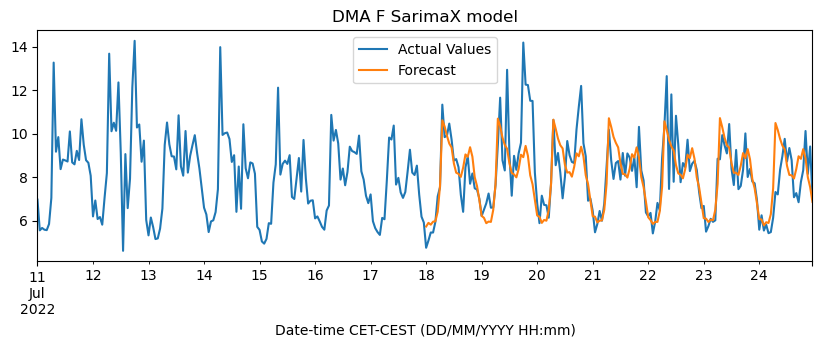

Performance indicators
DMA F SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.57            2.03             0.92           3.51 

Performance indicators
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82590D+00    |proj g|=  1.16362D-01


 This problem is unconstrained.



At iterate    5    f=  1.76889D+00    |proj g|=  1.19161D-01

At iterate   10    f=  1.71427D+00    |proj g|=  2.70977D-02

At iterate   15    f=  1.70862D+00    |proj g|=  2.68964D-02

At iterate   20    f=  1.70854D+00    |proj g|=  4.68074D-03

At iterate   25    f=  1.70834D+00    |proj g|=  1.47274D-02

At iterate   30    f=  1.70827D+00    |proj g|=  5.42979D-03

At iterate   35    f=  1.70824D+00    |proj g|=  6.40630D-03

At iterate   40    f=  1.70820D+00    |proj g|=  1.39201D-03

At iterate   45    f=  1.70819D+00    |proj g|=  1.32215D-03

At iterate   50    f=  1.70814D+00    |proj g|=  5.73044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

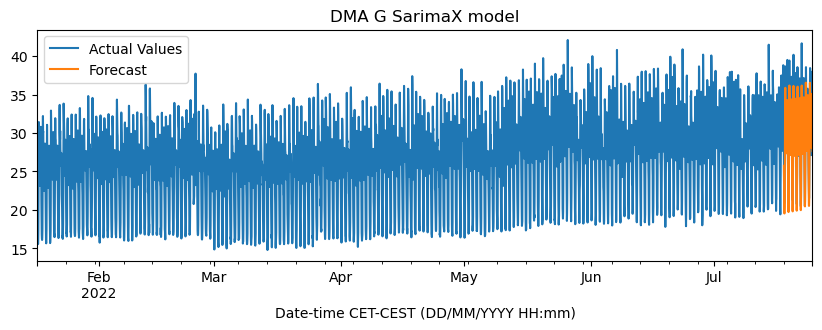

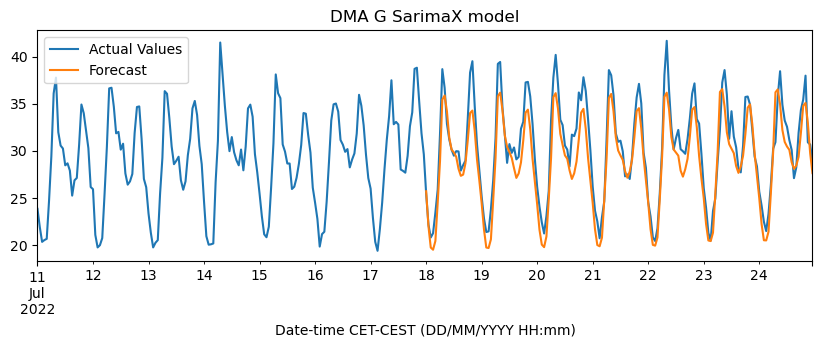

Performance indicators
DMA G SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.57            5.23             1.86           8.66 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80228D+00    |proj g|=  7.96260D-01


 This problem is unconstrained.



At iterate    5    f=  1.54620D+00    |proj g|=  3.29893D-01

At iterate   10    f=  1.51530D+00    |proj g|=  1.42611D-01

At iterate   15    f=  1.44818D+00    |proj g|=  5.58407D-02

At iterate   20    f=  1.44181D+00    |proj g|=  1.54904D-02

At iterate   25    f=  1.44143D+00    |proj g|=  5.06643D-03

At iterate   30    f=  1.44118D+00    |proj g|=  5.56874D-02

At iterate   35    f=  1.44055D+00    |proj g|=  1.06152D-02

At iterate   40    f=  1.43980D+00    |proj g|=  2.03991D-02

At iterate   45    f=  1.43956D+00    |proj g|=  4.01846D-03

At iterate   50    f=  1.43954D+00    |proj g|=  3.67540D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

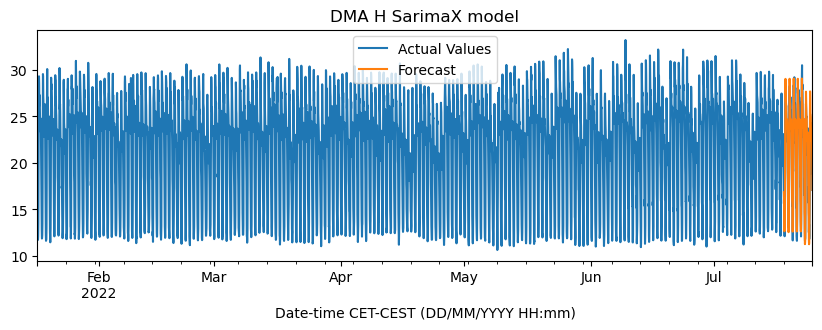

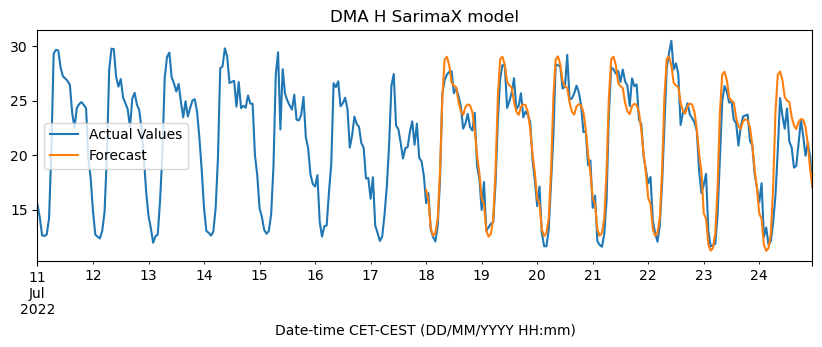

Performance indicators
DMA H SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.92            2.00             1.33           4.24 



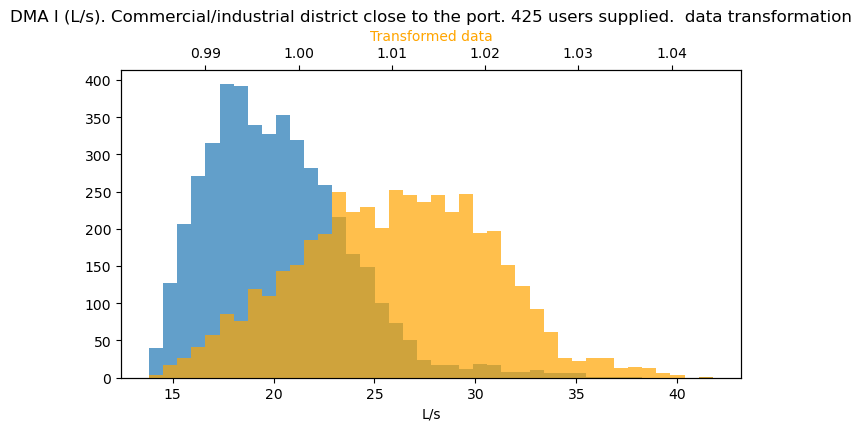

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.00258D+00    |proj g|=  6.54515D+01


 This problem is unconstrained.



At iterate    5    f= -4.03922D+00    |proj g|=  1.16485D+01

At iterate   10    f= -4.04263D+00    |proj g|=  4.30767D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f= -4.04316D+00    |proj g|=  2.48340D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     15     44      1     0     0   2.483D+00  -4.043D+00
  F =  -4.0431566235059790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


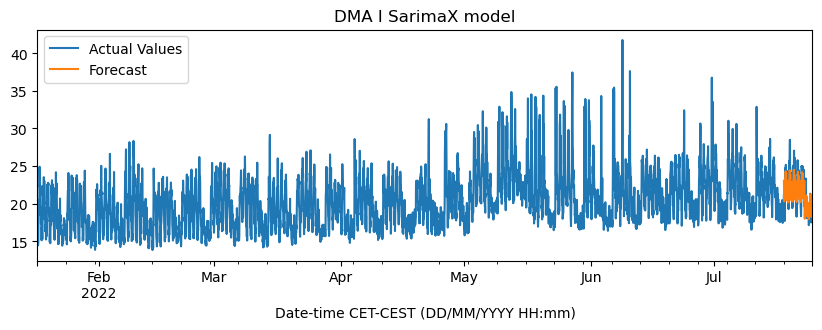

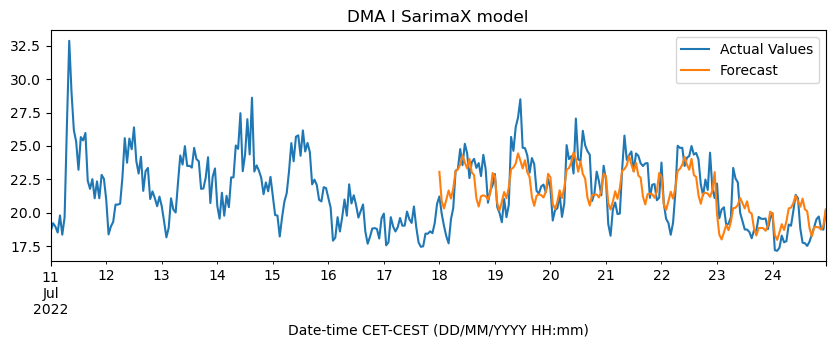

Performance indicators
DMA I SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.47            3.96             1.21           6.63 

Performance indicators


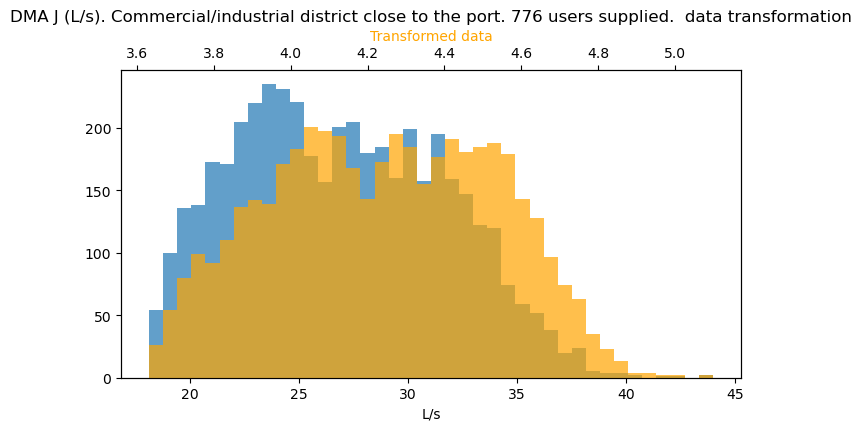

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.63919D-01    |proj g|=  2.89352D+00

At iterate    5    f= -9.95301D-01    |proj g|=  2.03215D-01

At iterate   10    f= -1.00467D+00    |proj g|=  3.36273D-01

At iterate   15    f= -1.00632D+00    |proj g|=  7.74664D-01

At iterate   20    f= -1.02009D+00    |proj g|=  1.74041D+00

At iterate   25    f= -1.02420D+00    |proj g|=  3.72454D+00

At iterate   30    f= -1.03635D+00    |proj g|=  5.27060D-01

At iterate   35    f= -1.03899D+00    |proj g|=  2.84838D-01

At iterate   40    f= -1.04772D+00    |proj g|=  4.19084D+00

At iterate   45    f= -1.05536D+00    |proj g|=  3.71991D-01

At iterate   50    f= -1.05765D+00    |proj g|=  1.20692D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

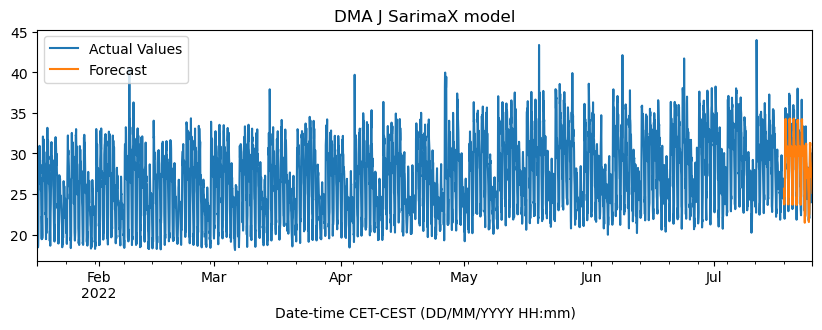

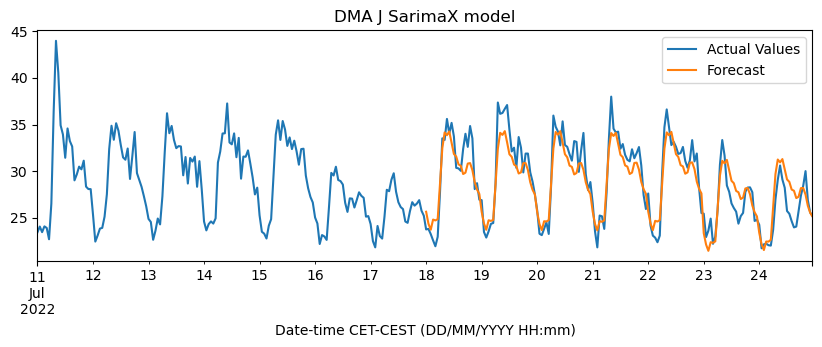

Performance indicators
DMA J SarimaX-Box-Cox 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.61            4.17             1.42           7.20 

Performance indicators


In [5]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

i = 0
# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    ## data transformation
    if dma not in ['DMA D (L/s)','DMA E (L/s)','DMA G (L/s)','DMA H (L/s)']:
        inflow_data_transformed, lmda = boxcox_transform(tseries_df,lmda=None,alpha=None,optimizer=None)

        # compare distributions of original and transformed data
        fig, ax = plt.subplots(figsize=(8,4))
        ax2 = ax.twiny()
        plt.title(dma + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. " + " data transformation")
        ax.hist(tseries_df.values, density=False,bins=40,alpha=0.7)
        ax2.hist(inflow_data_transformed.values, density=False,bins=40, color='orange', alpha=0.7)
        plt.ylabel('Counts')
        ax.set_xlabel("L/s")
        ax2.set_xlabel("Transformed data", color='orange')
        plt.show()


        # demand time series
        y = inflow_data_transformed
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        y_train_original, y_test_original = temporal_train_test_split(tseries_df, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.

        model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        # make predictions
        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

        # recover prediction in original format
        y_pred_recovered = inv_boxcox_tranform(y_pred['mean'], lmda, out=None)
        y_pred_recovered_lower = inv_boxcox_tranform(y_pred['mean_ci_lower'], lmda, out=None)
        y_pred_recovered_upper = inv_boxcox_tranform(y_pred['mean_ci_upper'], lmda, out=None)

        # plot results
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred_recovered.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        # plot forecast and last two weeks of time series
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred_recovered.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test_original, y_pred_recovered, dma[:5]+' SarimaX-Box-Cox 26-Weeks',return_df=1)
        results_df = pd.concat([results_df, df])
        print('Performance indicators')
    else:
        # demand time series
        y = tseries_df
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.
        model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        # plot forecast and last two weeks of time series
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX-Box-Cox 26-Weeks',return_df=1)
        results_df = pd.concat([results_df, df])
    i = i+1

In [6]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX-Box-Cox 26-Weeks,1.539,6.465,0.953,8.957
DMA B SarimaX-Box-Cox 26-Weeks,0.762,2.957,0.711,4.430
DMA C SarimaX-Box-Cox 26-Weeks,0.686,2.631,0.580,3.897
DMA D SarimaX-Box-Cox 26-Weeks,2.322,7.396,2.337,12.055
DMA E SarimaX-Box-Cox 26-Weeks,2.251,6.895,2.412,11.558
DMA F SarimaX-Box-Cox 26-Weeks,0.569,2.028,0.917,3.513
DMA G SarimaX-Box-Cox 26-Weeks,1.574,5.229,1.860,8.664
DMA H SarimaX-Box-Cox 26-Weeks,0.917,1.996,1.329,4.241
DMA I SarimaX-Box-Cox 26-Weeks,1.465,3.961,1.209,6.635
DMA J SarimaX-Box-Cox 26-Weeks,1.613,4.168,1.419,7.199


In [7]:
results_df['Total'].sum()

71.149